## References
This notebook is based on the following resources:
* [PyG Introduction notebook](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=Y9MOs8iSwKFD)
* [PyG Introduction Example Page](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html)

## Introduction

In this notebook we will explore the basic object of PyG library and integration with others. 
In the last part we will also see how PyG can be used to train a classification model. 

In [ ]:
import sys
import os
import torch
import time
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub
%matplotlib inline
sys.path.append(os.path.abspath("../../src"))
from logging_utils import setup_logger
from viz_utils import visualize_graph, visualize_embedding

In [2]:
# Set up the logger
log = setup_logger("notebook_logger")
log.info("🧪 Starting notebook")

[2025-05-07 22:19:16] [INFO] notebook_logger: 🧪 Starting notebook


In PyG, a graph is an object called `Data`. It can be obviously be defined by an edge list and nodes.

In [3]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
data

Data(x=[3, 1], edge_index=[2, 4])

/Users/rauldemaio/Projects Local/graph_nn_cookbook/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


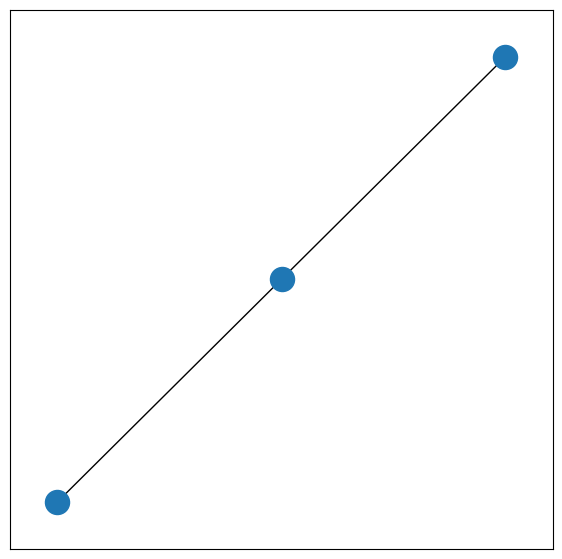

In [ ]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [5]:
for key in data.keys():
    print(key)
    print("-"*20)
    print(data[key])
    print('#'*20)

edge_index
--------------------
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
####################
x
--------------------
tensor([[-1.],
        [ 0.],
        [ 1.]])
####################


> PyG contains a large number of common benchmark datasets, e.g., all Planetoid datasets (Cora, Citeseer, Pubmed), all graph classification datasets from [TUDatasets](https://chrsmrrs.github.io/datasets/) and their cleaned versions, the QM7 and QM9 dataset, and a handful of 3D mesh/point cloud datasets like FAUST, ModelNet10/40 and ShapeNet. 

Source: [link](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html)

In this example, we select the KarateClub dataset which containes only one graph.

In [6]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print("Number of graphs in dataset: ", len(dataset))
print('======================')
print("Number of classes: ", dataset.num_classes)
print("Number of edge features: ", dataset.num_edge_features)
print("Number of node features: ", dataset.num_node_features)
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs in dataset:  1
Number of classes:  4
Number of edge features:  0
Number of node features:  34
Number of classes: 4


In [7]:
data = dataset[0]
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Few observations:
* a graph in PyG is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
* it holds 4 attributes:
    * `edge_index` property holds the information about the **graph connectivity**, *i.e.*, all edges. 
    * `x` are **node features**, *i.e.* vectors
    * `y` are **node labels**
    * the last is `train_mask`, which describes for which nodes we already know their community assigments.
* `Data` has also **utility functions**
* PyG does not distinguish between directed and undirected graph, *i.e.* undirected graph are a special case of directed graph such that for each edge there exists its inverse. 
* `Data`can be converted into networkx graphs. 

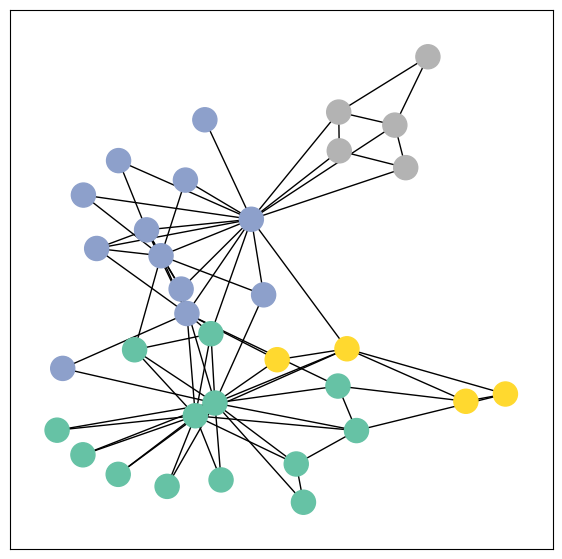

In [ ]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

We now define a graph neural network
* the GCN layer is a graph convolutional layer
* each GCN layer is equivalent to a single hop to first neighbors of each node
* 3 GCN means that the final embedding is calculated based on 3-hops neighborhoods

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):

    def __init__(self):

        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):

        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


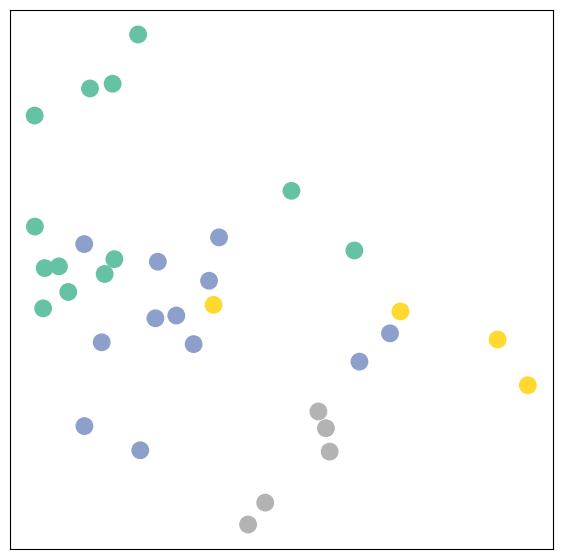

In [10]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

> [...] the model produces an embedding of nodes that closely resembles the community-structure of the graph.
> Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
> This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

We now train the GCN model based on a loss criterion and adopting the classical training process for neural networks. 

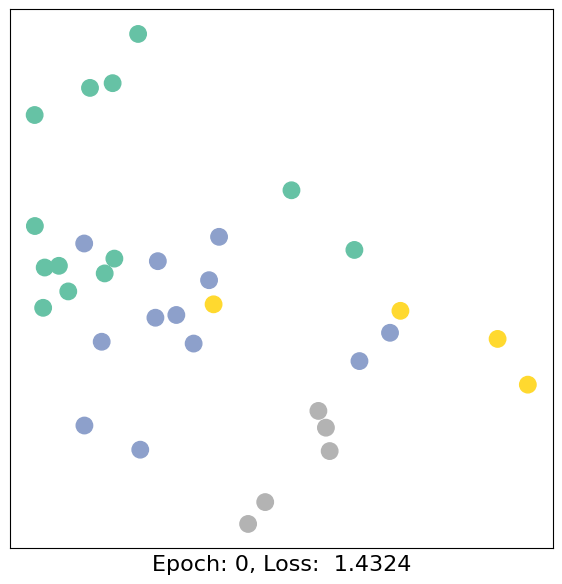

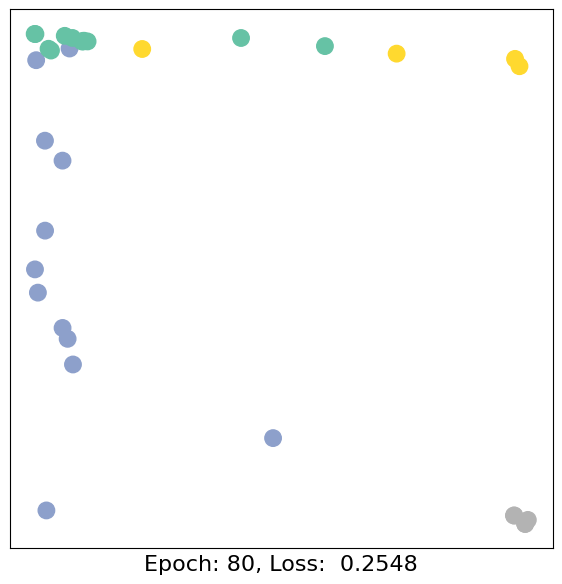

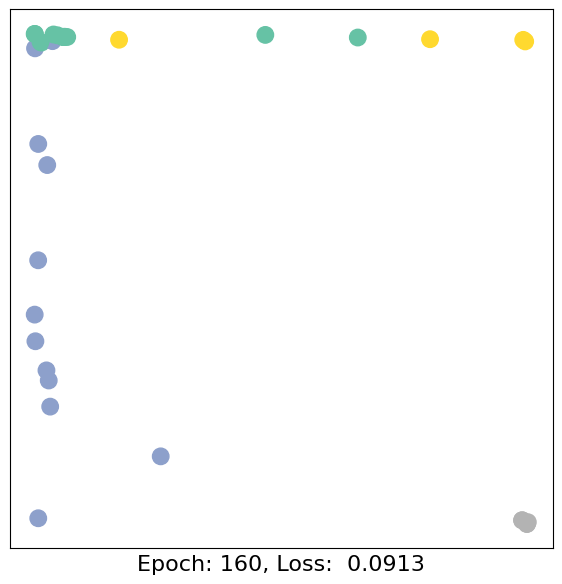

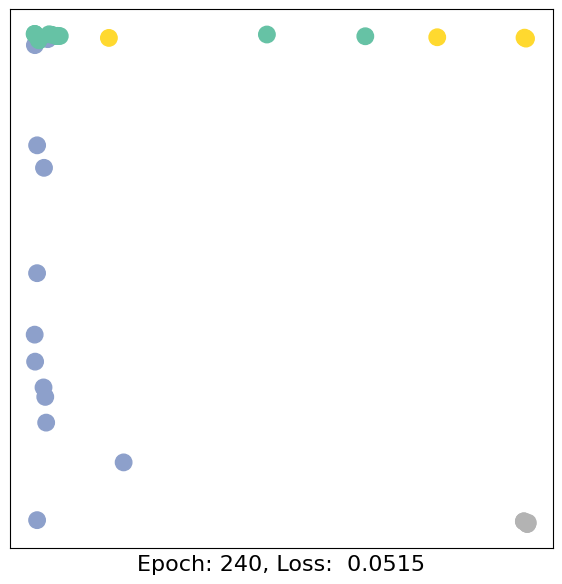

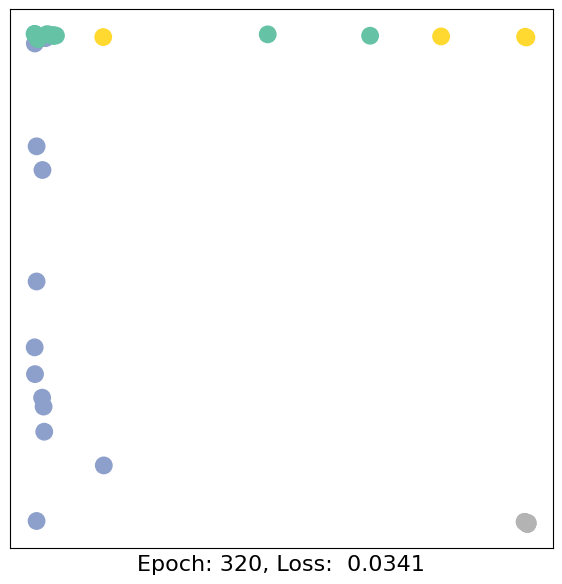

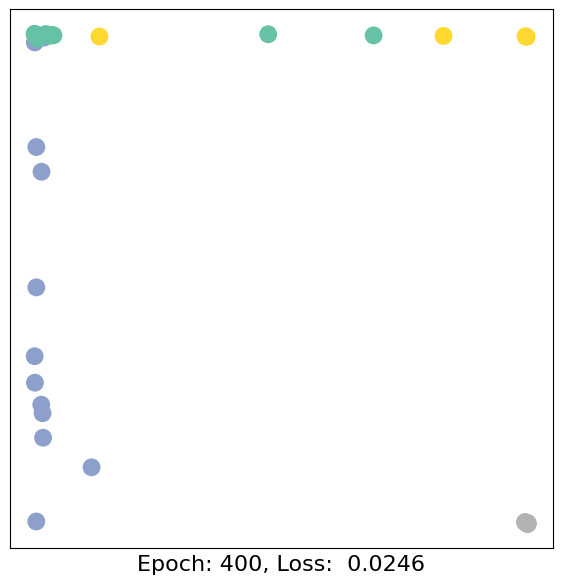

In [ ]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.


def train(data):

    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask],
        data.y[data.train_mask]
        )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h


for epoch in range(401):
    loss, h = train(data)
    if epoch % 80 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)